# Target, Evaluation Metircs and Baseline

In this notebook we:

* Define our target

* Discuss the evaluation metrics

* Build a Baseline Model


**NOTE:** Before starting exploring this notebook, I recommend checking `1-EDA.ipynb` notebook first - it contains Exploratory Data Analysis of the engines datasets and will help you get some understanding of the datasets. 

---

In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

First, let's read the data, we start with "FD001" dataset:

In [7]:
from utils import read_dataset

train_data, test_data, test_rul = read_dataset('FD001')

# The Target

Our taget will be estimating engines **Remaing Useful Life (RUL):** 

> RUL - remaining time that a component can function with an acceptable performance before it fails. In our case - it's a number of cycles from a current cycle to the engine's end of useful life (last cycle). 

Let's see RUL values for a couple of picked engines:

In [8]:
def calculate_RUL(X, upper_threshold=None):
    '''
    Calculate Remaining Useful Life per `unit`

    Parameters
    ----------
    X : pd.DataFrame, with `unit` and `time_cycles` columns
    upper_threshold: int, limit maximum RUL valus, default is None

    Returns
    -------
    np.array with Remaining Useful Life values
    '''
    lifetime = X.groupby(['unit'])['time_cycles'].transform(max)
    rul = lifetime - X['time_cycles']

    if upper_threshold:
        rul = np.where(rul > upper_threshold, upper_threshold, rul)

    return rul

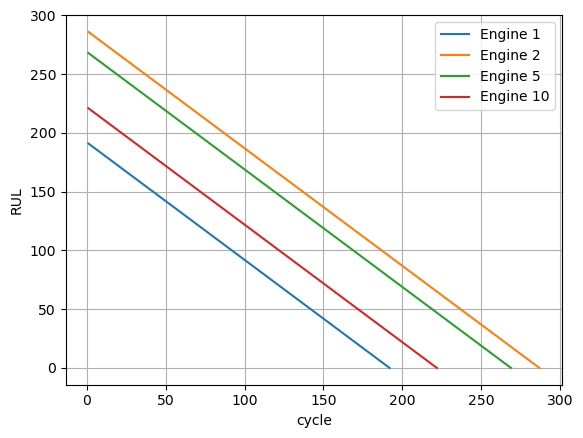

In [9]:
train_data['rul'] = calculate_RUL(train_data)

for _unit in [1, 2, 5, 10]:
    plt.plot(
        train_data[train_data['unit'] == _unit]['time_cycles'], 
        train_data[train_data['unit'] == _unit]['rul'], 
        label=f'Engine {_unit}'
    )
plt.legend()
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.grid()
plt.show()

And the distributions of RUL values in the Train/Test sets are visualized below:

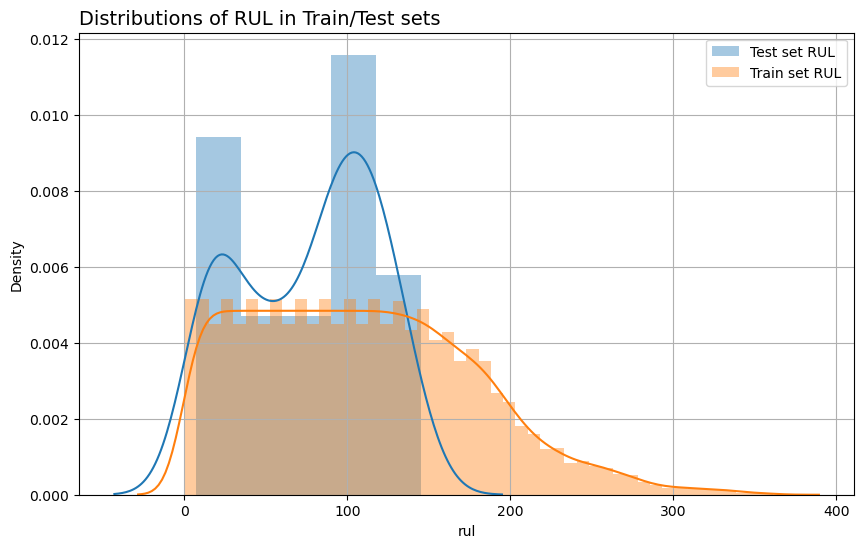

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Distributions of RUL in Train/Test sets', loc='left', size=14)
sns.distplot(test_rul, label='Test set RUL')
sns.distplot(train_data['rul'], label='Train set RUL')
ax.legend()
ax.grid()
plt.show()


As you can see from the figure above, the Train set contains samples with RUL way higher than in the Test set and this is because there're engines full lifetime data in the Train set, and in the Test set there's engines data till some period of time before its end of life. 

In most of the papers related to this problem, maximum value of RUL is being **limited to some constant value**. And the motivation is that a degradatation process will be only noticeable in the data after a unit has operated for some time. You can read more about this in this paper - https://www.researchgate.net/publication/224358896_Recurrent_neural_networks_for_remaining_useful_life_estimation.


So, we are going to **limit a maximum value of RUL with 135** (you can find details about how this specific value was picked in the paper following the link above) - please, see the changed RUL plots below:

In [11]:
RUL_UPPER_THRESHOLD = 135

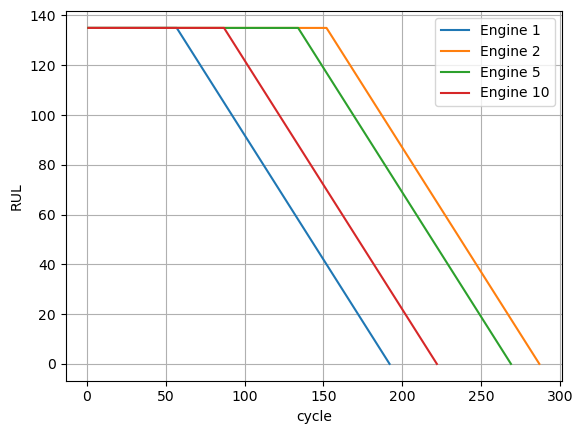

In [12]:
train_data['rul'] = calculate_RUL(train_data, upper_threshold=RUL_UPPER_THRESHOLD)

for _unit in [1, 2, 5, 10]:
    plt.plot(
        train_data[train_data['unit'] == _unit]['time_cycles'], 
        train_data[train_data['unit'] == _unit]['rul'], 
        label=f'Engine {_unit}'
    )
plt.legend()
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.grid()
plt.show()

train_data = train_data.drop(columns=['rul'])

# Evaluation Metrics

We are solving a Regression problem here and let's list and discuss the metrics we can use to evaluate the models for estimating Remaining Useful Life:

1. **RMSE** - Root Mean Squared Error - one of the standard metrics for regression, it's a squared root of averaged squared difference between actual and predicted values. An important characteristic of RMSE is that it penalizes larger errors more. 

$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}} $$

2. **MAE** - Mean Absolute Error - an average of absolute difference between actual and predicted values. MAE uses the same scale as the data and it's more robust to outliers.

$$ MAE = \frac{1}{n} \sum_{i=1}^{n}{ |y_i - \hat{y_i}| } $$

3. **MAPE** - Mean Absolute Percentage Error - average ratio of error over actual value, it measures the size of error as a percentage. **NOTE that this metric is not defined for $y=0$**. Also, if the actual values are very small, MAPE can be very high because of that. 
Another interesing characteristic of this metric is that **it's biased towards predictions which are lower than the actual values**. MAPE score will be lower for a prediction lower than the actual value, but it will be higher for a prediction which is higher than the actual value by the same amount, e.g. $ y=1, \hat{y}=2$, then $ MAPE = 100\% $, but when $ y=2, \hat{y}=1 $, then $MAPE=50\%$. 

$$ MAPE = 100 * \frac{1}{n} \sum_{i=1}^{n}{ |\frac{y_i - \hat{y_i}}{y_i}| } $$


4. **Custom Score** - this score is being used in most of the papers about estimating Remaining Useful Life for the turbofan data we use here, provided in Saxena et al. [1]. 

$$ SCORE = \sum_{i=1}^{n}{(e^{-\frac{(y_i - \hat{y_i})}{w}} - 1 ) }, $$

where $ w = 10 $, if $\hat{y} \geq y $
and $ w = 13 $, if $\hat{y} \lt y $

**NOTE that since this metric is a SUM, it cannot be compared across datasets of a different size!** It will be larger for a higher $n$. 

This scoring function assigns a **higher penalty when the Predicted RUL is higher than the true RUL** - please, see the figure below. The motivation for this is that late predictions are potentially more costly - predicting end of engine's life after it actually ended can cause much more problems than predicting it too early. 


[1] A. Saxena, K. Goebel, D. Simon, N. Eklund
Damage propagation modeling for aircraft engine run-to-failure simulation
2008 International Conference on Prognostics and Health Management, IEEE (2008), pp. 1-9


Now let's see how the **Custom score** (Item 4 on the list above) function assigns a higher weight to predictions higher than the actual:

In [13]:
def rul_score_f(err):
    if err >= 0:
        return np.exp(err / 10) - 1
    else:
        return np.exp(- err / 13) - 1


# Why this metric is a sum? Why not average?
# it means the metric increases with the size of the dataset
# and it means that it's not comparable between datasets
# of different sizes
def rul_score(true_rul, estimated_rul):
    err = estimated_rul - true_rul
    return np.sum([rul_score_f(x) for x in err])


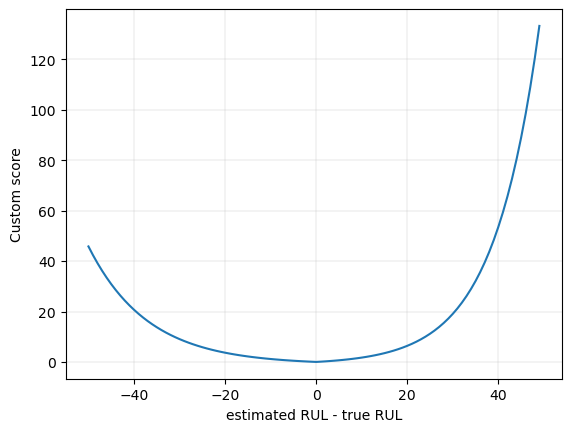

In [14]:
plt.plot(np.arange(-50, 50), 
         [rul_score_f(x) for x in np.arange(-50, 50)])
plt.xlabel('estimated RUL - true RUL')
plt.ylabel('Custom score')
plt.grid(linewidth=0.2)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


def rul_metrics_scorer(model, X, true_rul, metrics='all'):
    '''
    Calculate evaluation metrics:
        1. rmse - Root Mean Squared Error
        2. mae - Mean Absolute Error
        3. mape - Mean Absolute Percentage Error
        4. score - Custom metric with higher weight on underestimated RUL

    Returns
    -------
    dict with metrics
    '''
    scores_f = {
        'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error,
        'mape': mean_absolute_percentage_error,
        'score': rul_score
    }

    pred_rul = model.predict(X)

    def calculate_scores(metrics_list):
        return {m: scores_f[m](true_rul, pred_rul) for m in metrics_list}

    if metrics == 'all':
        return calculate_scores(scores_f.keys())
    elif isinstance(metrics, list):
        return calculate_scores(metrics)


# Prognostics Performance Evaluation Metrics

Prognostics has different performance requirements than general forecasting applications, which translates into differences in metrics. A couple of prognostics metrics are described in [2]: 


![](figures/prognostics_metrics.png)

*Figure source: [2]*

[2] Saxena, A.; Celaya, J.; Saha, B.; Saha, S.; Goebel, K. Metrics for Offline Evaluation of Prognostic Performance. Int. J. Progn. Health Manag. 2010


<br>
<br>


1. **Prognostic Horizon** - difference between time index when predictions first meet the specified performance criteria, specified in terms of error bounds $\alpha$, and the time index for end of life. It answers how much time it allows for any corrective action to be taken. The choice of error margin depends on time required for corrective action. 


![](figures/prognostic_horizon.png)
*Figure source: [2]*

See the function below:

In [16]:
def prognostic_horizon(pred_rul_dists, true_rul, beta=0.75, alphas=[-7, 7]):
    '''Calculate Prognostic Horizon 
    
    Parameters
    ----------
    pred_rul_dists : list w predicted distributions with method dist.cdf
    true_rul : np.array, ground truth Remaining Useful Life
    beta : float, probability threshold
    alphas : list, error margins
    
    Returns
    -------
    a tuple of prognostic horizon and corresponding probabilities
    '''
    assert len(alphas) == 2, "expect `alphas` to be a list of length 2"
    assert len(pred_rul_dists) == len(true_rul), "expect pred dists and true rul w same len"
    
    prog_horizon = 0
    prob_within_bounds = np.zeros(len(true_rul))
    
    horizon_found = False
    for i in range(len(true_rul)):
        pred_rul_cdfs = []
        for alpha in alphas:
            pred_rul_cdfs.append(
                pred_rul_dists[::-1][i].dist.cdf(np.maximum(true_rul[::-1][i] + alpha, 0)))
        beta_proba = pred_rul_cdfs[1] - pred_rul_cdfs[0]
        prob_within_bounds[::-1][i] = beta_proba
        
        if not horizon_found:
            if beta_proba >= beta:
                prog_horizon = true_rul[::-1][i]
            else:
                horizon_found = True 

    return int(prog_horizon), prob_within_bounds

2. **$\alpha-\lambda$ accuracy** - binary check if prediction at specific time instance $t_{\lambda}$ (fraction of time beetween time index when the first prediction is made and end of life) falls within error bounds ($\alpha$ bounds). Time instance $t_{\lambda}$ can be defined as a fraction of engines lifetime - $\lambda$:

$$t_{\lambda} = t_{0} + \lambda * (t_{EOL} - t_{0}),$$

where
* $t_{EOL}$ engined End Of Life
* $t_{0}$ is a time instance of a first prediction made.


![](figures/alpha_lambda_performance.png)
*Figure source: [2]*

See the function below:

In [17]:
def alpha_lambda_acc(pred_rul_dists, true_rul, time_frac=[0.5, 0.75, 0.9], beta=0.75, alpha=0.1):
    '''Calculate Alpha-Lambda Accuracy
    
    Parameters
    ----------
    pred_rul_dists : list w predicted distributions with method dist.cdf
    true_rul : np.array, ground truth Remaining Useful Life
    time_frac : list of time fractions for predictions
    beta : float, probability threshold
    alpha : float, error margin around actual RUL
    
    Returns
    -------
    a tuple of binary alpha-lambda acc and corresponding probabilities
    '''
    assert len(pred_rul_dists) == len(true_rul), "expect pred dists and true rul w same len"
    
    n_time_inst = len(true_rul)
    
    alha_lambda_acc = np.full(len(time_frac), -1)
    pred_probas = np.full(len(time_frac), -1.0)
    for i, t_frac in enumerate(time_frac):
        t_instance = int(np.round(n_time_inst * t_frac))
        t_inst_true_rul = true_rul[t_instance]
        upper_bound = np.maximum(np.round(t_inst_true_rul * (1 + alpha)), 2)
        low_bound = np.round(t_inst_true_rul * (1 - alpha))
        
        t_inst_pred = pred_rul_dists[t_instance]
        
        pred_probas[i] = t_inst_pred.dist.cdf(upper_bound) - t_inst_pred.dist.cdf(low_bound)
        
        if pred_probas[i] >= beta:
            alha_lambda_acc[i] = 1
        else:
            alha_lambda_acc[i] = 0

    return alha_lambda_acc, pred_probas


3. **Relative Accuracy** - error relative to actual RUL at specific time instance $t_{\lambda}$:

$$RA_{\lambda} = 1 - \frac{RUL error_{\lambda}}{true RUL_{\lambda}}$$

Time instance $t_{\lambda}$ can be defined as a fraction of engines lifetime - $\lambda$:

$$t_{\lambda} = t_{0} + \lambda * (t_{EOL} - t_{0}),$$

where
* $t_{EOL}$ engined End Of Life
* $t_{0}$ is a time instance of a first prediction made.

<br>
See the function below:

In [18]:
def relative_accuracy(pred_rul, true_rul, time_frac=[0.5, 0.75, 0.9]):
    '''Calculate Relative Accuracy
    
    Parameters
    ----------
    pred_rul : np.array, w predicted Remaining Useful Life
    true_rul : np.array, ground truth Remaining Useful Life
    time_frac : list of time fractions for predictions
    
    Returns
    -------
    np.array of relative accuracy at every time instance from `time_frac`
    '''
    assert len(pred_rul) == len(true_rul), "expect predicted and true rul w same length"

    n_time_inst = len(true_rul)

    rel_acc = np.full(len(time_frac), -1.0)
    for i, t_frac in enumerate(time_frac):
        t_instance = int(np.round(n_time_inst * t_frac))
        t_inst_true_rul = true_rul[t_instance]
        t_inst_pred = pred_rul[t_instance]

        rel_acc[i] = 1 - np.abs(t_inst_true_rul - t_inst_pred) / t_inst_true_rul

    return rel_acc

# Baseline Model

We start with a Baseline Model which will be our reference point to which compare all the other models. For instance, a baseline model can be even a random guess, and if a model you developed can't beat such baseline - that's your red flag.

Our Baseline Model will be based on a random sample from engines RUL in the train set. Let's go through the steps it takes:

1. for a given test engine, consider only engines in the train set which lifespan was higher than the current cycle for the test engine
2. estimate Remaining Useful Life as a difference between AVG lifespan of the sampled engines from the train set and the test engine current cycle
3. if there are no engines in the train set with a higher lifespan than the test engine, estimate RUL with a randomly picked integer from [1, 50]

And here's the Baseline Model implemented:

In [19]:
class BaselineModel:
    '''
    Estimate Remaining Useful Life as an Average RUL of 
    engines with longer lifetime.
    
    If there are no older engines in train set, it randomly samples from [0, 50]. 
    '''
    def fit(self, X):
        '''
        Parameters
        ----------
        X : pd.DataFrame, engines data
        '''
        self.lifetime = X.groupby(['unit'])['time_cycles'].max().reset_index(name='last_cycle')
        
    def predict(self, X):
        '''
        Parameters
        ----------
        X : pd.DataFrame, engines data
        '''
        rul = []
        for current_cycle in X['time_cycles'].values:
            lifetime_sample = self.lifetime.loc[
                (self.lifetime['last_cycle'] > current_cycle),
                'last_cycle'
            ]

            if lifetime_sample.shape[0] == 0:
                estimated_rul = np.random.randint(low=1, high=50, size=1)[0]
            else:
                estimated_rul = np.round(lifetime_sample.mean()) - current_cycle

            rul.append(estimated_rul)
        return np.array(rul)


In [20]:
def plot_residuals_vs_actual(actual_rul, predicted_rul,
                             title='Test set - Residuals vs Actual RUL',
                             xlabel='Actual RUL', ylabel='Residuals',
                             ax=None):
    '''A scatter plot of residuals vs '''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    residual = predicted_rul - actual_rul
    ax.set_title(title)
    sns.regplot(x=actual_rul, y=residual, lowess=True, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.grid()


<br>

Initialize an instance of a BaselineModel and train it with the train dataset:

In [21]:
baseline_model = BaselineModel()
baseline_model.fit(train_data)

And here we test it on the TEST dataset:

In [22]:
test_last_cycles = test_data.groupby('unit', as_index=False)['time_cycles'].max()

In [23]:
rul_metrics_scorer(baseline_model, test_last_cycles, test_rul)

{'rmse': np.float64(36.63836786757838),
 'mae': 31.37,
 'mape': 0.906682116160513,
 'score': np.float64(7657.158284814168)}

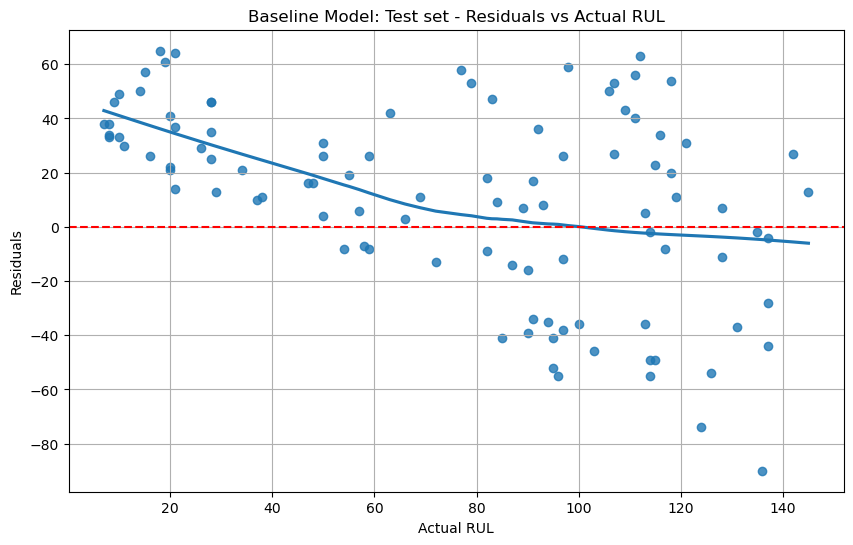

In [24]:
test_pred = baseline_model.predict(test_last_cycles)

plot_residuals_vs_actual(test_rul, test_pred,title='Baseline Model: Test set - Residuals vs Actual RUL')

This gives us starting metrics scores (evaluated on the TEST data) that we will try to improve with ML models.

---